Load HyperParameters

In [19]:
from neat_src import loadHyp, updateHyp
from domain import load_task
from neat_src import DataGatherer, Neat 
from domain.config import games
from domain.task_gym import GymTask

game = games["slimevolley"]
task = GymTask(game)

hyp_default = 'p/default_neat.json'
hyp_adjust = "p/volley.json"
fileName = "volley"

hyp = loadHyp(pFileName=hyp_default, load_task=load_task)
updateHyp(hyp,load_task,hyp_adjust)

# neat = Neat(hyp)

	*** Running with hyperparameters:  p/volley.json 	***


#### Convert Policy model to Ind in Neat 

In [20]:
import json
import numpy as np
import gym, os
import slimevolleygym
import slimevolleygym.mlp as mlp
from slimevolleygym.mlp import games as games
from slimevolleygym.mlp import Model
from slimevolleygym import multiagent_rollout as rollout


# Settings
random_seed = 612
population_size = 128
total_tournaments = 500000
save_freq = 1000


# Log results
logdir = "ga_rotation_je"
if not os.path.exists(logdir):
  os.makedirs(logdir)

def mutate(param, param_count):
  return param + np.random.normal(size=param_count) * 0.1

curr_policy = Model(games['slimevolleylite'])
prev_policy = Model(games['slimevolleylite'])

/var/folders/nn/nbsb8w3570zfgs23h2s0cdzm0000gn/T/ipykernel_11755/869475039.py:26: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  curr_policy = Model(games['slimevolleylite'])
/var/folders/nn/nbsb8w3570zfgs23h2s0cdzm0000gn/T/ipykernel_11755/869475039.py:27: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  prev_policy = Model(games['slimevolleylite'])


In [21]:
# indiv object --> policy model 

hidden_shapes = [2] # hidden layers shapes 
specific_policy = Model(games['slimevolleylite'], hidden_layers=hidden_shapes)

model = specific_policy 
params = list(zip(model.weight, model.bias)) # list of (w, b) tuples 


/var/folders/nn/nbsb8w3570zfgs23h2s0cdzm0000gn/T/ipykernel_11755/3244457810.py:4: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  specific_policy = Model(games['slimevolleylite'], hidden_layers=hidden_shapes)


In [22]:
# Slime Environment Specific model -> Ind convertion function 
from neat_src import Ind, initIndiv
from vis.viewInd import viewInd 

temp_shapes = [(12, 3), (3, 2)] # debug getlayer functional variable 

indiv = Ind.from_shapes(temp_shapes)
indiv.express()

# visualize individual network 
fig, ax = viewInd(indiv, "slimevolley") # this is in-correct, edge is not correctly assigned ...

# of Connections in ANN:  47


In [23]:
# Indiv --> Policy Model 
game = games['slimevolleylite']
load_policy = Model.from_indiv(indiv, game)

In [24]:
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image
import io

# Convert matplotlib figure to PIL Image
def fig2img(fig):
    # Save figure to a temporary buffer.
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    buf.seek(0)
    return Image.open(buf)

matplotlib.use('Agg')  # Use Agg backend for better memory management

frames = []  # Store frames

prev_indiv = Ind.from_shapes([(2, 1)])
prev_indiv.express()
connG, nodeG = prev_indiv.conn, prev_indiv.node

# Generate and store frames
for i in range(50):
    # Create new figure for each frame
    fig, ax = plt.subplots(figsize=(10, 10))
    
    if np.random.randint(2) == 0:
    # if False:
        connG, nodeG, _ = prev_indiv.mutAddNode(connG, nodeG, None, 1, hyp)
    else:
        connG, nodeG, _ = prev_indiv.mutAddConn(connG, nodeG, None, 1, hyp) # adding Connection risks involving cyclic connections
        
    indiv = Ind(connG, nodeG)
    if indiv.express():
        fig, ax = viewInd(indiv, "slimevolley")  # Use viewInd as is
        prev_indiv = indiv
        connG, nodeG = prev_indiv.conn, prev_indiv.node
    else:
        print("Failed to express :: Bad mutation")
        
    img = fig2img(fig)
    frames.append(img)
    plt.close(fig)


... Adding Node  4
... Adding Connection From  1.0  to  4.0
... Adding Connection From  4.0  to  3.0
# of Connections in ANN:  5
... Adding Node  5
... Adding Connection From  1.0  to  5.0
... Adding Connection From  5.0  to  4.0
# of Connections in ANN:  7
... Adding Node  6
... Adding Connection From  0.0  to  6.0
... Adding Connection From  6.0  to  3.0
# of Connections in ANN:  9
 :::: Adding Connection from  [0.]  to  [4.]
# of Connections in ANN:  10
... Adding Node  7
... Adding Connection From  0.0  to  7.0
... Adding Connection From  7.0  to  6.0
# of Connections in ANN:  12
 :::: Adding Connection from  [0.]  to  [5.]
# of Connections in ANN:  13
 :::: Adding Connection from  [5.]  to  [3.]
# of Connections in ANN:  14
 :::: Adding Connection from  [7.]  to  [4.]
# of Connections in ANN:  15
... Adding Node  8
... Adding Connection From  4.0  to  8.0
... Adding Connection From  8.0  to  3.0
# of Connections in ANN:  17
 :::: Adding Connection from  [1.]  to  [7.]
# of Connect

KeyboardInterrupt: 

In [28]:
from neat_src import getNodeMap, obtainOutgoingConnections

nodeG, connG = prev_indiv.node, prev_indiv.conn
nodeMap = getNodeMap(nodeG, connG)

    
sources = np.random.permutation(list(nodeMap.keys()))
# for src_node_id in sources:
#     # src_node_id = 12
#     src_node_layer = nodeMap[src_node_id][0] # take source node according to index
#     dest_node_ids = [dest_node_id for dest_node_id in nodeMap if nodeMap[dest_node_id][0] > src_node_layer]
    
#     # remove pre-existing outgoing connections
#     exist_conn = obtainOutgoingConnections(connG, src_node_id)
#     dest_node_ids = np.setdiff1d(dest_node_ids, exist_conn).astype(int)
#     # print(":: Starting Node: ", src_node_id)
#     # print("Possible additional connections: ", dest_node_ids)
#     # break

# of Connections in ANN:  22


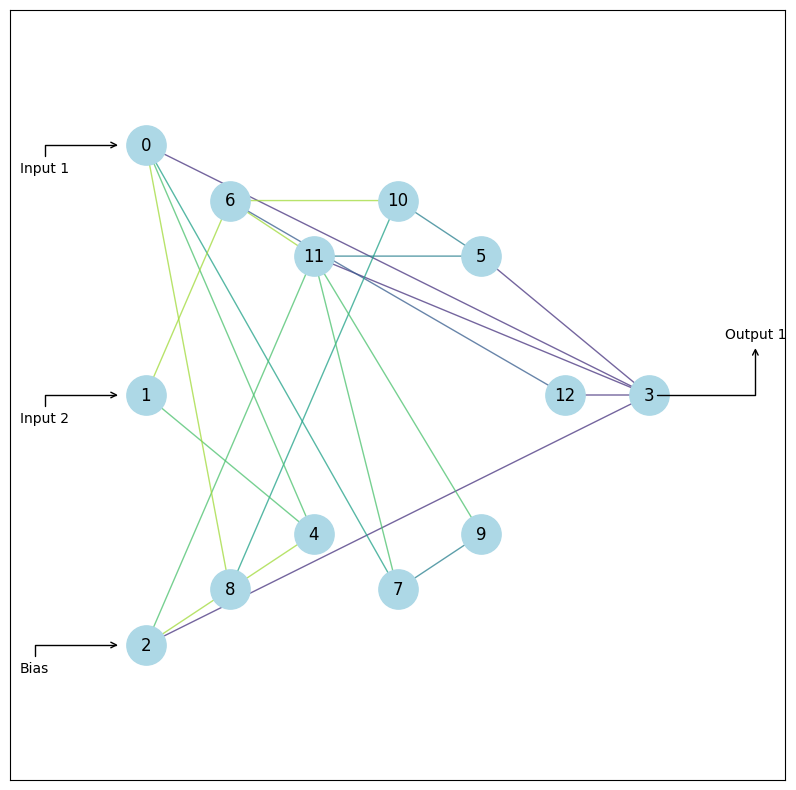

In [13]:
indiv = Ind(connG, nodeG)
indiv.express()

fig, ax = viewInd(prev_indiv, "slimevolley")
# fig, ax = viewInd(indiv, "slimevolley") # 2 -> 4 connection is not added here .. ()
fig

# connG, nodeG, _ = indiv.mutAddConn(connG, nodeG, None, 1, hyp)

In [26]:
wMat = indiv.wMat
# from neat_src import getLayer 
# layer = getLayer(wMat)
getLayer(wMat)

array([0, 0, 0, 3, 1, 2, 1, 4, 2, 2, 1, 5])

In [33]:
wMat[np.isnan(wMat)] = 0
nNode = wMat.shape[0]

# Create adjacency matrix (1 where connection exists)
adj = (wMat != 0).astype(int)

# Find nodes with no incoming connections (sources)
in_degree = adj.sum(axis=0)
sources = np.where(in_degree == 0)[0]

# Initialize layers
layers = np.full(nNode, -1)
layers[sources] = 0 

current_layer = 0 
while True: 
    unassigned_mask = (layers == -1)
    if not np.any(unassigned_mask):
        print("All nodes are assigned layers")
    break


In [51]:
inputs_assigned = ~np.any(adj[unassigned_mask], axis=0) # node without incoming unassigned node 
next_layer = np.where(unassigned_mask & inputs_assigned)[0] # next layer node ids (since each time we only assign one layer)



In [25]:
# from neat_src import getLayer 
def getLayer(wMat):
  """Get layer of each node in weight matrix using a more efficient approach.
  Instead of iterating until convergence, we can use a graph traversal approach.

  Args:
    wMat  - (np_array) - ordered weight matrix [N X N]

  Returns:
    layer - [int]      - layer # of each node
  """
  wMat[np.isnan(wMat)] = 0
  nNode = wMat.shape[0]
  
  # Create adjacency matrix (1 where connection exists)
  adj = (wMat != 0).astype(int)
  
  # Find nodes with no incoming connections (sources)
  in_degree = adj.sum(axis=0)
  sources = np.where(in_degree == 0)[0]
  
  # Initialize layers
  layers = np.full(nNode, -1)
  layers[sources] = 0
  
  # Use BFS to assign layers
  current_layer = 0
  while True:
    # Find nodes that receive input only from already-assigned layers
    unassigned_mask = (layers == -1)
    if not np.any(unassigned_mask):
      break
      
    # Find nodes whose inputs are all from previous layers
    inputs_assigned = ~np.any(adj[unassigned_mask], axis=0) # for unassigned node, check if there is any incoming node with assigned layer
    next_layer = np.where(unassigned_mask & inputs_assigned)[0] # get unassigned node with incoming node with assigned layer
    
    if len(next_layer) == 0:
      break
      
    current_layer += 1
    layers[next_layer] = current_layer
    
  return layers


In [ ]:
order, wMat = getNodeOrder(self.node, self.conn)

In [ ]:
def validate_connections(conn_matrix):
    """Validate connection matrix for duplicates"""
    # Get source-target pairs
    source_target_pairs = list(zip(conn_matrix[1], conn_matrix[2]))
    # Check for duplicates
    unique_pairs = set(source_target_pairs)
    return len(source_target_pairs) == len(unique_pairs)


In [9]:
# Issue: rejecting residual/skipped connection (problem not with Add Conn Mutation)
# Bug in the getNodeOrder function ... 

from neat_src import getNodeOrder
order, wMat = getNodeOrder(nodeG, connG)
wMat

False

In [11]:
connG[1] = 

(5, 58)

In [6]:
# Save frames as GIF directly using PIL
frames[0].save(
    'network_evolution.gif',
    save_all=True,
    append_images=frames[1:],
    duration=500,  # Duration for each frame in milliseconds
    loop=0        # 0 means loop forever
)

In [27]:
nodeG, connG = indiv.node, indiv.conn
# connG_new, node_new, _ = indiv.mutAddConn(connG, nodeG, innov=None, gen=1)
connG_new, nodeG_new, _ = indiv.mutAddNode(connG, nodeG, None, 1, hyp)

# of Connections in ANN:  49


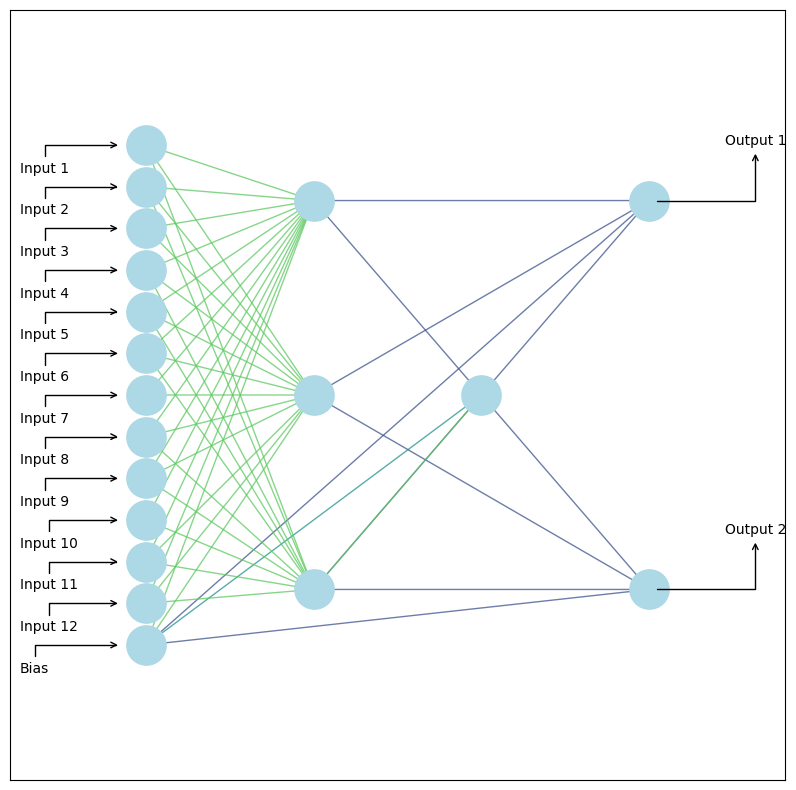

In [30]:
new_indiv = Ind(connG_new, nodeG_new)
new_indiv.express()
fig, ax = viewInd(new_indiv, "slimevolley") # this is in-correct, edge is not correctly assigned ...
